In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
from datetime import datetime
import pickle
import warnings
import ast
import re
warnings.filterwarnings("ignore")

In [48]:
def transform_candle_from_1s_to_1m(DF, ws):
    def candle1m(df, ws):  
        rv_names = ['rv'+str(w)+'m' for w in ws]
        dff = df.copy()
        res3 = dff.groupby('date_hm')[['date_hm', 'open']].first()
        res4 = dff.groupby('date_hm')[['high']].max()
        res5 = dff.groupby('date_hm')[['low']].min()
        res6 = dff.groupby('date_hm')[['close']+rv_names].last()
        res = pd.concat([res3, res4, res5, res6], axis=1)
        res[rv_names] = res[rv_names].replace(0, np.nan).ffill()
        return res
    
    df = DF.iloc[:, :6].copy()
    df['time'] = pd.date_range(start='2023-01-01 00:00:00', periods=len(df), freq='1S')
    df['date_hm'] = df['time'].dt.strftime('%Y-%m-%d %H:%M')
    for w in ws:
        df['rv'+str(w)+'m'] = np.log(df['close']/df['close'].shift()).rolling(window=w*60).std()*np.sqrt(365 * 24 * 60 * 60)
    return candle1m(df, ws)    


def find_decimal_places(number):
    number_str = str(number)
    if 'e' in number_str:
        number_str, remain = number_str.split('e')
        remain = int(remain[1:])
    if '.' not in str(number):
        return 0
    decimal_point_index = number_str.index('.')
    decimal_places = len(number_str) - decimal_point_index - 1  
    return decimal_places + remain if 'e' in str(number) else decimal_places

def plot_series(x):
    plt.plot(range(len(x)), x.to_list())

def get_candle_with_vamp(coin, ws, vamp_delta):
    def vamp(df, k):
        def calculate_ask_vamp(row, k):
            dv = row['qav1m'] / k
            if row['dva'] >= dv:
                return row['ask']
            elif (row['dva']+row['dva1']) >= dv:
                return dv / (row['as']+(dv-row['dva'])/row['ask1'])
            elif (row['dva']+row['dva1']+row['dva2']) >= dv:
                return dv / (row['as']+row['as1']+(dv-row['dva']-row['dva1'])/row['ask2'])
            elif (row['dva']+row['dva1']+row['dva2']+row['dva3']) >= dv:
                return dv / (row['as']+row['as1']+row['as2']+(dv-row['dva']-row['dva1']-row['dva2'])/row['ask3'])
            elif (row['dva']+row['dva1']+row['dva2']+row['dva3']+row['dva4']) >= dv:
                return dv / (row['as']+row['as1']+row['as2']+row['as3']+(dv-row['dva']-row['dva1']-row['dva2']-row['dva3'])/row['ask4'])
            else:
                return (row['dva']+row['dva1']+row['dva2']+row['dva3']+row['dva4']) / (row['as']+row['as1']+row['as2']+row['as3']+row['as4'])

        def calculate_bid_vamp(row, k):
            dv = row['qav1m'] / k
            if row['dvb'] >= dv:
                return row['bid']
            elif (row['dvb']+row['dvb1']) >= dv:
                return dv / (row['bs']+(dv-row['dvb'])/row['bid1'])
            elif (row['dvb']+row['dvb1']+row['dvb2']) >= dv:
                return dv / (row['bs']+row['bs1']+(dv-row['dvb']-row['dvb1'])/row['bid2'])
            elif (row['dvb']+row['dvb1']+row['dvb2']+row['dvb3']) >= dv:
                return dv / (row['bs']+row['bs1']+row['bs2']+(dv-row['dvb']-row['dvb1']-row['dvb2'])/row['bid3'])
            elif (row['dvb']+row['dvb1']+row['dvb2']+row['dvb3']+row['dvb4']) >= dv:
                return dv / (row['bs']+row['bs1']+row['bs2']+row['bs3']+(dv-row['dvb']-row['dvb1']-row['dvb2']-row['dvb3'])/row['bid4'])
            else:
                return (row['dvb']+row['dvb1']+row['dvb2']+row['dvb3']+row['dvb4']) / (row['bs']+row['bs1']+row['bs2']+row['bs3']+row['bs4'])

        return (df.apply(lambda row: calculate_ask_vamp(row, k), axis=1)+df.apply(lambda row: calculate_bid_vamp(row, k), axis=1))/2      
    
    def candle1mm(df, ws):  
        rv_names = ['rv'+str(w)+'m' for w in ws]
        dff = df.copy()
        res3 = dff.groupby('date_hm')[['date_hm', 'open', 'vamp']].first()
        res4 = dff.groupby('date_hm')[['high']].max()
        res5 = dff.groupby('date_hm')[['low']].min()
        res6 = dff.groupby('date_hm')[['close']+rv_names].last()
        res = pd.concat([res3, res4, res5, res6], axis=1)
        res[rv_names] = res[rv_names].replace(0, np.nan).ffill()
        return res   
    
    df2 = pd.read_excel(coin+'.xlsx', index_col=0) # data collected lively from record_trade_BTC.py in Hummingbot
    column_names = ['time']+['ask', 'as', 'bid', 'bs'] + ['ask1', 'as1', 'bid1', 'bs1'] + ['ask2', 'as2', 'bid2', 'bs2'] + ['ask3', 'as3', 'bid3', 'bs3'] + ['ask4', 'as4', 'bid4', 'bs4']
    df2 = df2[column_names]
    df2 = df2.dropna()
    df2['mid'] = (df2['ask']+df2['bid'])/2
    df2['dva'] = df2['ask'] * df2['as']
    df2['dvb'] = df2['bid'] * df2['bs']
    for i in ['1', '2', '3', '4']:
        df2['dva'+i] = df2['ask'+i] * df2['as'+i]
        df2['dvb'+i] = df2['bid'+i] * df2['bs'+i]  
    DF = pd.read_csv('candles_binance_'+coin+'-USDT_1s.csv')
    DF = DF.iloc[:, :7]
    DF['time'] = DF['timestamp'] // 1000
    DF = DF[(DF['time'] >= df2['time'].iloc[0]) &(DF['time'] <= df2['time'].iloc[-1])].reset_index(drop=True)
    df2['qav'] = DF['quote_asset_volume'].to_list()
    df2['qav1m'] = df2['qav'].rolling(60).sum()
    
    DF['vamp'] = round(vamp(df2, vamp_delta), rounding_precision) 

    DF['time'] = pd.date_range(start='2023-01-01 00:00:00', periods=len(DF), freq='1S')
    DF['second'] = DF['time'].dt.second
    DF['date_hm'] = DF['time'].dt.strftime('%Y-%m-%d %H:%M')
    for w in ws:
        DF['rv'+str(w)+'m'] = np.log(DF['close']/DF['close'].shift()).rolling(window=w*60).std()*np.sqrt(365 * 24 * 60 * 60)
    return candle1mm(DF, ws) 


def pnl(df, algo_flag, x, s=1, l=1, k=0, plot_flag=False, xlsx_flag=False):  
    df = df.copy()
    
    pv_hold = 100000 / df['open'][0] * df['close'] + 100000    
    pv_hold = [200000]+pv_hold.to_list()
    
    scaler = (df['rv'+str(s)+'m']/df['rv'+str(l)+'m']).fillna(1) if algo_flag > 0 else pd.Series(1, index=df.index)
    xs = round(pd.Series(x, index=df.index)*scaler, rounding_precision) 
    xs[xs < tick_size] = tick_size
    
    initial_base_balances = 100000
    initial_q = initial_base_balances / df['open'][0]
    quote_size = initial_q / 100
    
    base_balances, q = initial_base_balances, initial_q
    quote_balances = q*df.iloc[0,:]['open']
    portfolio_value = base_balances + quote_balances
    qs, portfolio_values = [q], [portfolio_value]
    trade_num = 0
    
    # cash, trade_num, q, qs = 0, 0, 0, [0]
    # portfolio_value, portfolio_values = 0, [0]
    for index, row in df.iterrows():  
        inventory_imbalance = quote_balances / base_balances - 1
        inventory_control = round(-k*inventory_imbalance*scaler[index], rounding_precision) 
        
        fair_mid = row['open'] if algo_flag!=3 else row['vamp']
        if inventory_imbalance > 0:
            bp, ap = fair_mid-xs[index]+inventory_control, fair_mid+xs[index]
        else:
            bp, ap = fair_mid-xs[index], fair_mid+xs[index]+inventory_control
        if bp >= row['low']: base_balances, q, trade_num = base_balances-quote_size*bp, q+quote_size, trade_num+1     
        if ap <= row['high']: base_balances, q, trade_num = base_balances+quote_size*ap, q-quote_size, trade_num+1    
        
        quote_balances = q*row['close']
        portfolio_value = base_balances + quote_balances
        
        if index[-2:] == '59': 
            q_to_sell = round((quote_balances - portfolio_value/2) / row['close'])
            base_balances += q_to_sell * row['close']
            q -= q_to_sell
        portfolio_values.append(portfolio_value)
        qs.append(q)
        
    pnls = pd.Series(np.diff(np.array(portfolio_values)), index=df.index)
    pnls_hold = pd.Series(np.diff(np.array(pv_hold)), index=df.index)
    pnls = pnls - pnls_hold
    
    qs = pd.Series(qs[1:], index=df.index)
    portfolio_values = pd.Series(portfolio_values[1:], index=df.index)
    #portfolio_values -= portfolio_values[0]
    if plot_flag is True:
        def plot_series(x):
            plt.figure()
            plt.plot(range(len(x)), x.to_list())
        plot_series(qs)
        #plot_series(pnls)
        plot_series(portfolio_values)
    if xlsx_flag == True:
        return np.sqrt(365*24*60) * pnls.mean() / pnls.std(), trade_num / len(df)
    return np.sqrt(365*24*60) * pnls.mean() / pnls.std(), trade_num / len(df), portfolio_values, qs


def performance_report(prefix, coin, df1, algo3=False, vamp_delta=False):
    # Load the optimal parameters
    res0 = pd.read_excel(prefix+coin+' algo0_SR_#trade.xlsx', index_col=0)
    my_array = res0['SR']
    top_index_values = np.argsort(my_array)[::-1].iloc[:10]
    top_ten_values = my_array.iloc[top_index_values]
    xs = [float(x) for x in top_ten_values.index]
    algo0_x = xs[0]
    res1 = pd.read_excel(prefix+coin+' algo1_SR_#trade.xlsx', index_col=0)
    my_array = res1['SR']
    top_index_values1 = np.argsort(my_array)[::-1].iloc[:10]
    top_ten_values1 = my_array[top_index_values1]    
    algo1_xsl = ast.literal_eval(top_ten_values1.index[1])
    res2 = pd.read_excel(prefix+coin+' algo2_SR_#trade.xlsx', index_col=0)
    my_array = res2['SR']
    top_index_values2 = np.argsort(my_array)[::-1].iloc[:10]
    top_ten_values2 = my_array[top_index_values2]    
    algo2_xslk = ast.literal_eval(top_ten_values2.index[0])

    # P&L of Buy&Hold
    plt.figure(figsize=(12,6))
    pv_hold = 100000 / df1['open'][0] * df1['close'] + 100000
    plot_series(pv_hold)
    plt.title('Portfolio Value of Buy&Hold (50-50 in USDT&Token at the Beginning)', fontsize=18)

    # Relative P&L of algo 0/1/2
    plt.figure(figsize=(12,6))
    sr0, tn0, pv0, qs0 = pnl(df1, algo_flag=0, x=algo0_x)
    sr1, tn1, pv1, qs1 = pnl(df1, algo_flag=1, x=algo1_xsl[0], s=algo1_xsl[1], l=algo1_xsl[2])
    sr2, tn2, pv2, qs2 = pnl(df1, algo_flag=2, x=algo2_xslk[0], s=algo2_xslk[1], l=algo2_xslk[2], k=algo2_xslk[3])
    plot_series(pv0-pv_hold)
    plot_series(pv1-pv_hold)
    plot_series(pv2-pv_hold)
    names = ['Naive MM Strategy', 'Volatility Adjusted MM Strategy', 'Volatility and Inventory Adjusted MM Strategy']
    if algo3==True:
        sr3, tn3, pv3, qs3 = pnl(DF1, algo_flag=3, x=algo2_xslk[0], s=algo2_xslk[1], l=algo2_xslk[2], k=algo2_xslk[3])
        plot_series(pv3-pv_hold)
        names = ['Naive MM Strategy', 'Volatility Adjusted MM Strategy', 
         'Volatility and Inventory Adjusted MM Strategy', 
         'Volatility, Inventory and Fair Price Adjusted MM Strategy']
    plt.title('Relative Portfolio Value to Buy&Hold', fontsize=18)
    plt.legend(names)
    
    # The variation of inventory value
    plt.figure(figsize=(12,6))
    plot_series(qs0*df1['close'])
    plot_series(qs1*df1['close'])
    plot_series(qs2*df1['close'])
    if algo3==True:
        plot_series(qs3*DF1['close'])
    plt.title('Inventory Value', fontsize=18)
    plt.legend(names)

    # The tabular results 
    if algo3==True:
        Parameters = ['x = '+str(algo0_x), '(x,s,l) = '+str(algo1_xsl), '(x,s,l,k) = '+str(algo2_xslk), '(x,s,l,k,delta) = '+str(algo2_xslk)[:-1]+', '+str(vamp_delta)+')']
        df_params = pd.DataFrame(Parameters, index=names, columns=['Parameters'])
        df_params['SR of Relative P&L to Buy&Hold'] = [sr0, sr1, sr2, sr3]
        df_params['Traded%'] = [tn0*100, tn1*100, tn2*100, tn3*100]
        df_params['Std of Inventory Value'] = [(qs0*DF1['close']).std(), (qs1*DF1['close']).std(), (qs2*DF1['close']).std(), (qs3*DF1['close']).std()] 
    else:
        Parameters = ['x = '+str(algo0_x), '(x,s,l) = '+str(algo1_xsl), '(x,s,l,k) = '+str(algo2_xslk)]
        df_params = pd.DataFrame(Parameters, index=names, columns=['Parameters'])
        df_params['SR of Relative P&L to Buy&Hold'] = [sr0, sr1, sr2]
        df_params['Traded%'] = [tn0*100, tn1*100, tn2*100]
        df_params['Std of Inventory Value'] = [(qs0*df1['close']).std(), (qs1*df1['close']).std(), (qs2*df1['close']).std()]
    return df_params.transpose()

# Optimization Procedure ( Use BTC-USDT as example )

In [53]:
# now = datetime.now()
# prefix = str(now.month) + str(now.day)   
prefix = '1126'
coin = 'BTC'
DF = pd.read_csv('candles_binance_'+coin+'-USDT_1s.csv') # Candles data collected from downlaod_candles.py in Hummingbot
ws = [1, 3, 5, 10, 15, 20, 30, 60, 120]
df1 = transform_candle_from_1s_to_1m(DF, ws)
rounding_precision = find_decimal_places(df1['open'][0])
tick_size = 10**(-rounding_precision)

In [8]:
# Grid Search for algo 0
def grid_search_0(xs):
    res = pd.DataFrame(columns=['SR', '#trade'])
    for x in xs:
        print(x)
        sr_and_tradenum = pnl(df1, algo_flag=0, x=x, s=1, l=1, k=0, plot_flag=False, xlsx_flag=True)
        if sr_and_tradenum[1] < 0.2:
            break
        res.loc[str(x)] = sr_and_tradenum
    return res

end = round((df1['high'] - df1['low']).quantile(0.9), rounding_precision)
test_limit = 200
if end//tick_size >= test_limit:
    xs = [round(x,rounding_precision) for x in np.linspace(tick_size, end, test_limit)]
else:
    xs = [round(tick_size*i, rounding_precision) for i in range(1, test_limit)]
res0 = grid_search_0(xs)
# res0.to_excel(prefix+coin+' algo0_SR_#trade.xlsx')
res0


0.01
0.25
0.49
0.73
0.98
1.22
1.46
1.7
1.94
2.18
2.43
2.67
2.91
3.15
3.39
3.63
3.87
4.12
4.36
4.6
4.84
5.08
5.32
5.56
5.81
6.05
6.29
6.53
6.77
7.01
7.26
7.5
7.74
7.98
8.22
8.46
8.7
8.95
9.19
9.43
9.67
9.91
10.15
10.39
10.64
10.88
11.12
11.36
11.6
11.84
12.09
12.33
12.57
12.81
13.05
13.29
13.53
13.78
14.02
14.26
14.5
14.74
14.98
15.22
15.47
15.71
15.95
16.19
16.43
16.67
16.92
17.16
17.4
17.64
17.88
18.12
18.36
18.61
18.85
19.09
19.33
19.57
19.81
20.06
20.3
20.54
20.78
21.02
21.26
21.5
21.75
21.99
22.23
22.47
22.71
22.95
23.19
23.44
23.68
23.92
24.16
24.4
24.64
24.89
25.13
25.37
25.61
25.85
26.09
26.33
26.58
26.82
27.06
27.3
27.54
27.78
28.02
28.27
28.51
28.75
28.99
29.23
29.47
29.72
29.96
30.2
30.44
30.68
30.92
31.16


,SR,#trade
0.01,-18.076290,1.598016
0.25,-16.651832,1.366171
0.49,-21.224911,1.354067
0.73,-21.050640,1.344345
0.98,-18.974781,1.333135
...,...,...
29.96,6.877271,0.211905
30.2,-1.965738,0.208333
30.44,-3.716125,0.205556
30.68,-12.020954,0.202679


In [8]:
# Get the parameters with top 10 SR values      
res0 = pd.read_excel(prefix+coin+' algo0_SR_#trade.xlsx', index_col=0)
my_array = res0['SR']
top_index_values = np.argsort(my_array)[::-1].iloc[:10]
top_ten_values = my_array.iloc[top_index_values]
xs = [float(x) for x in top_ten_values.index]
algo0_x = xs[0]
top_ten_values

28.51    13.426139
23.44    13.357445
27.06    11.219333
28.75    10.637394
23.19     9.984512
25.13     9.253193
21.50     9.088013
17.88     8.748492
25.61     8.126879
20.06     7.992919
Name: SR, dtype: float64

In [36]:
# Grid Search for algo 1
def grid_search_1(xs, short_windows, long_windows):
    res = pd.DataFrame(columns=['SR', '#trade'])
    for x in xs:
        for s in short_windows:
            for l in long_windows:
                if s < l:
                    print((x, s, l))
                    res.loc[str((x,s,l))] = pnl(df1, algo_flag=1, x=x, s=s, l=l, k=0, plot_flag=False, xlsx_flag=True)         
    return res

ss = [1]
ls = ws[1:]
res1 = grid_search_1(xs, ss, ls)
# res1.to_excel(prefix+coin+' algo1_SR_#trade.xlsx')
res1

(28.51, 1, 3)
(28.51, 1, 5)
(28.51, 1, 10)
(28.51, 1, 15)
(28.51, 1, 20)
(28.51, 1, 30)
(28.51, 1, 60)
(28.51, 1, 120)
(23.44, 1, 3)
(23.44, 1, 5)
(23.44, 1, 10)
(23.44, 1, 15)
(23.44, 1, 20)
(23.44, 1, 30)
(23.44, 1, 60)
(23.44, 1, 120)
(27.06, 1, 3)
(27.06, 1, 5)
(27.06, 1, 10)
(27.06, 1, 15)
(27.06, 1, 20)
(27.06, 1, 30)
(27.06, 1, 60)
(27.06, 1, 120)
(28.75, 1, 3)
(28.75, 1, 5)
(28.75, 1, 10)
(28.75, 1, 15)
(28.75, 1, 20)
(28.75, 1, 30)
(28.75, 1, 60)
(28.75, 1, 120)
(23.19, 1, 3)
(23.19, 1, 5)
(23.19, 1, 10)
(23.19, 1, 15)
(23.19, 1, 20)
(23.19, 1, 30)
(23.19, 1, 60)
(23.19, 1, 120)
(25.13, 1, 3)
(25.13, 1, 5)
(25.13, 1, 10)
(25.13, 1, 15)
(25.13, 1, 20)
(25.13, 1, 30)
(25.13, 1, 60)
(25.13, 1, 120)
(21.5, 1, 3)
(21.5, 1, 5)
(21.5, 1, 10)
(21.5, 1, 15)
(21.5, 1, 20)
(21.5, 1, 30)
(21.5, 1, 60)
(21.5, 1, 120)
(17.88, 1, 3)
(17.88, 1, 5)
(17.88, 1, 10)
(17.88, 1, 15)
(17.88, 1, 20)
(17.88, 1, 30)
(17.88, 1, 60)
(17.88, 1, 120)
(25.61, 1, 3)
(25.61, 1, 5)
(25.61, 1, 10)
(25.61, 1, 15

,SR,#trade
"(28.51, 1, 3)",5.033346,0.237202
"(28.51, 1, 5)",4.034659,0.240774
"(28.51, 1, 10)",13.926605,0.248512
"(28.51, 1, 15)",-7.560197,0.255655
"(28.51, 1, 20)",-0.121178,0.256448
...,...,...
"(20.06, 1, 15)",-9.727533,0.432738
"(20.06, 1, 20)",-4.178533,0.442361
"(20.06, 1, 30)",-2.662813,0.450298
"(20.06, 1, 60)",-0.897231,0.468452


In [9]:
# Get the parameters with top 10 SR values     
res1 = pd.read_excel(prefix+coin+' algo1_SR_#trade.xlsx', index_col=0)
my_array = res1['SR']
top_index_values1 = np.argsort(my_array)[::-1].iloc[:10]
top_ten_values1 = my_array[top_index_values1]    
algo1_xsl = ast.literal_eval(top_ten_values1.index[1])
print(top_ten_values1)

(27.06, 1, 10)    18.999039
(28.75, 1, 20)    16.575252
(27.06, 1, 3)     16.414382
(28.75, 1, 10)    15.695855
(28.51, 1, 10)    13.926605
(23.19, 1, 5)     13.792086
(28.75, 1, 60)    12.917421
(23.19, 1, 15)     8.556576
(21.5, 1, 30)      7.759800
(23.44, 1, 5)      7.663234
Name: SR, dtype: float64


In [40]:
# Grid Search for algo 2
def grid_search_2(xs, short_windows, long_windows, ks):
    res = pd.DataFrame(columns=['SR', '#trade'])
    for x in xs:
        for s in short_windows:
            for l in long_windows:
                if s < l:
                    for k in ks:
                        print((x, s, l, k))
                        res.loc[str((x,s,l,k))] = pnl(df1, algo_flag=2, x=x, s=s, l=l, k=k, xlsx_flag=True)         
    return res

def round_up_to_nearest_10(number):
    return math.ceil(number / 10) * 10

ks = [round(tick_size*i, rounding_precision) for i in np.linspace(1, round_up_to_nearest_10(max(xs) // tick_size)+1, 10+1)]
res2 = grid_search_2(xs, ss, ls, ks)
# res2.to_excel(prefix+coin+' algo2_SR_#trade.xlsx')
res2

(28.51, 1, 3, 0.01)
(28.51, 1, 3, 2.89)
(28.51, 1, 3, 5.77)
(28.51, 1, 3, 8.65)
(28.51, 1, 3, 11.53)
(28.51, 1, 3, 14.41)
(28.51, 1, 3, 17.29)
(28.51, 1, 3, 20.17)
(28.51, 1, 3, 23.05)
(28.51, 1, 3, 25.93)
(28.51, 1, 3, 28.81)
(28.51, 1, 5, 0.01)
(28.51, 1, 5, 2.89)
(28.51, 1, 5, 5.77)
(28.51, 1, 5, 8.65)
(28.51, 1, 5, 11.53)
(28.51, 1, 5, 14.41)
(28.51, 1, 5, 17.29)
(28.51, 1, 5, 20.17)
(28.51, 1, 5, 23.05)
(28.51, 1, 5, 25.93)
(28.51, 1, 5, 28.81)
(28.51, 1, 10, 0.01)
(28.51, 1, 10, 2.89)
(28.51, 1, 10, 5.77)
(28.51, 1, 10, 8.65)
(28.51, 1, 10, 11.53)
(28.51, 1, 10, 14.41)
(28.51, 1, 10, 17.29)
(28.51, 1, 10, 20.17)
(28.51, 1, 10, 23.05)
(28.51, 1, 10, 25.93)
(28.51, 1, 10, 28.81)
(28.51, 1, 15, 0.01)
(28.51, 1, 15, 2.89)
(28.51, 1, 15, 5.77)
(28.51, 1, 15, 8.65)
(28.51, 1, 15, 11.53)
(28.51, 1, 15, 14.41)
(28.51, 1, 15, 17.29)
(28.51, 1, 15, 20.17)
(28.51, 1, 15, 23.05)
(28.51, 1, 15, 25.93)
(28.51, 1, 15, 28.81)
(28.51, 1, 20, 0.01)
(28.51, 1, 20, 2.89)
(28.51, 1, 20, 5.77)
(28.51,

(23.19, 1, 10, 23.05)
(23.19, 1, 10, 25.93)
(23.19, 1, 10, 28.81)
(23.19, 1, 15, 0.01)
(23.19, 1, 15, 2.89)
(23.19, 1, 15, 5.77)
(23.19, 1, 15, 8.65)
(23.19, 1, 15, 11.53)
(23.19, 1, 15, 14.41)
(23.19, 1, 15, 17.29)
(23.19, 1, 15, 20.17)
(23.19, 1, 15, 23.05)
(23.19, 1, 15, 25.93)
(23.19, 1, 15, 28.81)
(23.19, 1, 20, 0.01)
(23.19, 1, 20, 2.89)
(23.19, 1, 20, 5.77)
(23.19, 1, 20, 8.65)
(23.19, 1, 20, 11.53)
(23.19, 1, 20, 14.41)
(23.19, 1, 20, 17.29)
(23.19, 1, 20, 20.17)
(23.19, 1, 20, 23.05)
(23.19, 1, 20, 25.93)
(23.19, 1, 20, 28.81)
(23.19, 1, 30, 0.01)
(23.19, 1, 30, 2.89)
(23.19, 1, 30, 5.77)
(23.19, 1, 30, 8.65)
(23.19, 1, 30, 11.53)
(23.19, 1, 30, 14.41)
(23.19, 1, 30, 17.29)
(23.19, 1, 30, 20.17)
(23.19, 1, 30, 23.05)
(23.19, 1, 30, 25.93)
(23.19, 1, 30, 28.81)
(23.19, 1, 60, 0.01)
(23.19, 1, 60, 2.89)
(23.19, 1, 60, 5.77)
(23.19, 1, 60, 8.65)
(23.19, 1, 60, 11.53)
(23.19, 1, 60, 14.41)
(23.19, 1, 60, 17.29)
(23.19, 1, 60, 20.17)
(23.19, 1, 60, 23.05)
(23.19, 1, 60, 25.93)
(23.

(25.61, 1, 30, 23.05)
(25.61, 1, 30, 25.93)
(25.61, 1, 30, 28.81)
(25.61, 1, 60, 0.01)
(25.61, 1, 60, 2.89)
(25.61, 1, 60, 5.77)
(25.61, 1, 60, 8.65)
(25.61, 1, 60, 11.53)
(25.61, 1, 60, 14.41)
(25.61, 1, 60, 17.29)
(25.61, 1, 60, 20.17)
(25.61, 1, 60, 23.05)
(25.61, 1, 60, 25.93)
(25.61, 1, 60, 28.81)
(25.61, 1, 120, 0.01)
(25.61, 1, 120, 2.89)
(25.61, 1, 120, 5.77)
(25.61, 1, 120, 8.65)
(25.61, 1, 120, 11.53)
(25.61, 1, 120, 14.41)
(25.61, 1, 120, 17.29)
(25.61, 1, 120, 20.17)
(25.61, 1, 120, 23.05)
(25.61, 1, 120, 25.93)
(25.61, 1, 120, 28.81)
(20.06, 1, 3, 0.01)
(20.06, 1, 3, 2.89)
(20.06, 1, 3, 5.77)
(20.06, 1, 3, 8.65)
(20.06, 1, 3, 11.53)
(20.06, 1, 3, 14.41)
(20.06, 1, 3, 17.29)
(20.06, 1, 3, 20.17)
(20.06, 1, 3, 23.05)
(20.06, 1, 3, 25.93)
(20.06, 1, 3, 28.81)
(20.06, 1, 5, 0.01)
(20.06, 1, 5, 2.89)
(20.06, 1, 5, 5.77)
(20.06, 1, 5, 8.65)
(20.06, 1, 5, 11.53)
(20.06, 1, 5, 14.41)
(20.06, 1, 5, 17.29)
(20.06, 1, 5, 20.17)
(20.06, 1, 5, 23.05)
(20.06, 1, 5, 25.93)
(20.06, 1, 5, 

,SR,#trade
"(28.51, 1, 3, 0.01)",5.033400,0.237202
"(28.51, 1, 3, 2.89)",-7.226203,0.232540
"(28.51, 1, 3, 5.77)",0.676684,0.228869
"(28.51, 1, 3, 8.65)",-5.717939,0.227282
"(28.51, 1, 3, 11.53)",-4.913493,0.225595
...,...,...
"(20.06, 1, 120, 17.29)",4.132040,0.469345
"(20.06, 1, 120, 20.17)",5.501043,0.467262
"(20.06, 1, 120, 23.05)",5.032492,0.466071
"(20.06, 1, 120, 25.93)",6.085962,0.464087


In [10]:
# Get the parameters with top 10 SR values   
res2 = pd.read_excel(prefix+coin+' algo2_SR_#trade.xlsx', index_col=0)
my_array = res2['SR']
top_index_values2 = np.argsort(my_array)[::-1].iloc[:10]
top_ten_values2 = my_array[top_index_values2]    
algo2_xslk = ast.literal_eval(top_ten_values2.index[0])
print(top_ten_values2)

(28.75, 1, 10, 2.89)    20.167112
(27.06, 1, 10, 0.01)    18.999073
(27.06, 1, 10, 2.89)    18.089039
(28.51, 1, 10, 2.89)    17.985706
(28.75, 1, 10, 5.77)    17.591787
(27.06, 1, 15, 2.89)    17.179623
(28.75, 1, 20, 0.01)    16.575294
(27.06, 1, 3, 0.01)     16.414459
(27.06, 1, 10, 5.77)    16.139964
(28.75, 1, 10, 0.01)    15.695978
Name: SR, dtype: float64


# BTC Performance Report
#### Optimal parameters are calculated beforehand with the procedure introduced above, now loaded from an external file.

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy
Parameters,x = 28.51,"(x,s,l) = (28.75, 1, 20)","(x,s,l,k) = (28.75, 1, 10, 2.89)"
SR of Relative P&L to Buy&Hold,13.426139,16.575252,20.167112
Traded%,23.065476,25.277778,24.365079
Std of Inventory Value,7298.581926,6950.27234,4799.268587


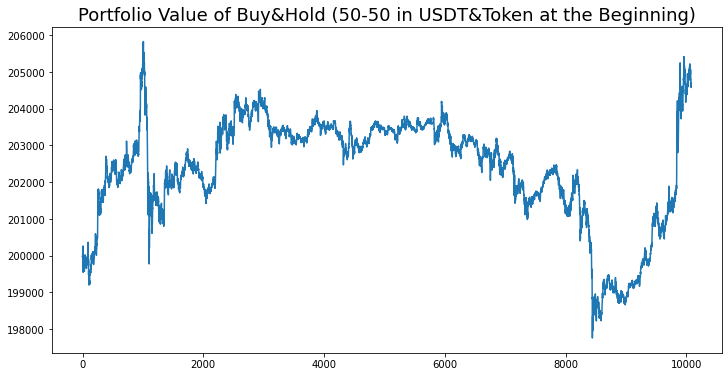

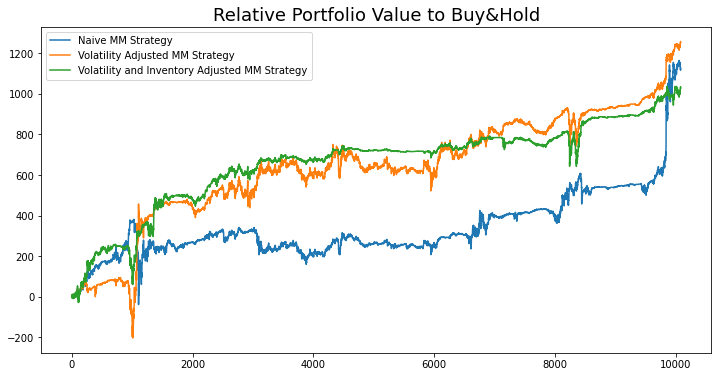

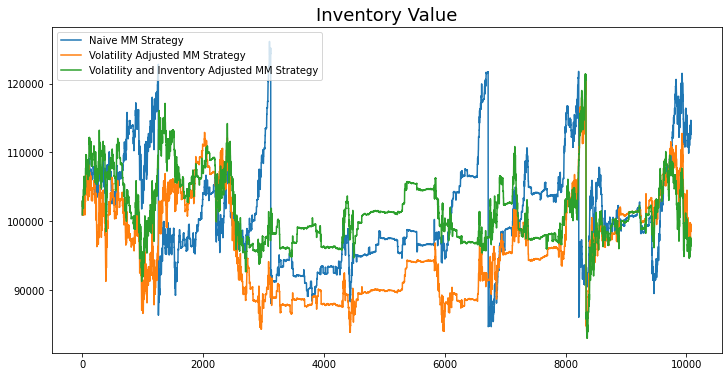

In [54]:
# now = datetime.now()
# prefix = str(now.month) + str(now.day)   
prefix = '1126'
coin = 'BTC'
DF = pd.read_csv('candles_binance_'+coin+'-USDT_1s.csv') # Candles data collected from downlaod_candles.py in Hummingbot
df1 = transform_candle_from_1s_to_1m(DF, ws)
rounding_precision = find_decimal_places(df1['open'][0])
tick_size = 10**(-rounding_precision)
performance_report(prefix, coin, df1)

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy,"Volatility, Inventory and Fair Price Adjusted MM Strategy"
Parameters,x = 28.51,"(x,s,l) = (28.75, 1, 20)","(x,s,l,k) = (28.75, 1, 10, 2.89)","(x,s,l,k,delta) = (28.75, 1, 10, 2.89, 20)"
SR of Relative P&L to Buy&Hold,-64.976873,40.571557,10.503644,25.298553
Traded%,16.806723,23.94958,24.789916,23.529412
Std of Inventory Value,4339.161993,1416.251728,1756.60629,1672.133878


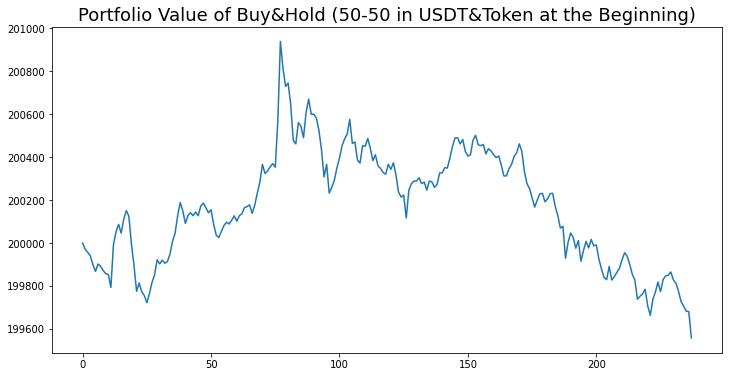

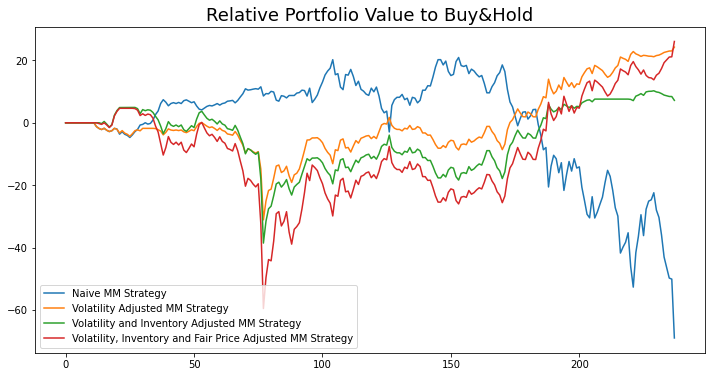

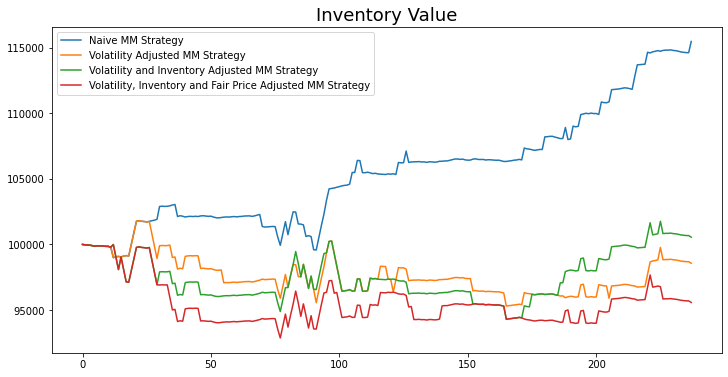

In [56]:
# Get candle data with VAMP from orderbook data, which has a different time period with the previous plot
vamp_delta = 20
DF1 = get_candle_with_vamp(coin, ws, vamp_delta)
performance_report(prefix, coin, DF1, True, vamp_delta)

# ETH Performance Report

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy
Parameters,x = 1.9,"(x,s,l) = (2.0, 1, 20)","(x,s,l,k) = (2.1, 1, 20, 2.1)"
SR of Relative P&L to Buy&Hold,-4.673389,-0.459978,0.897828
Traded%,25.198413,26.765873,23.759921
Std of Inventory Value,3211.548772,2926.101026,2655.795564


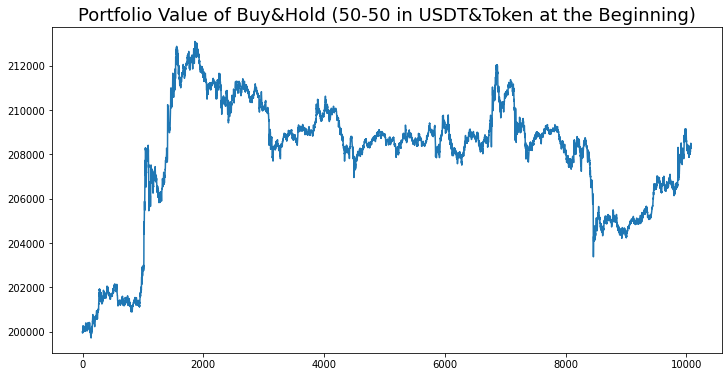

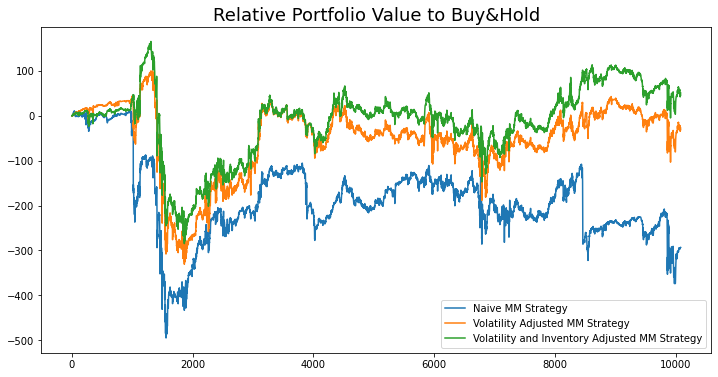

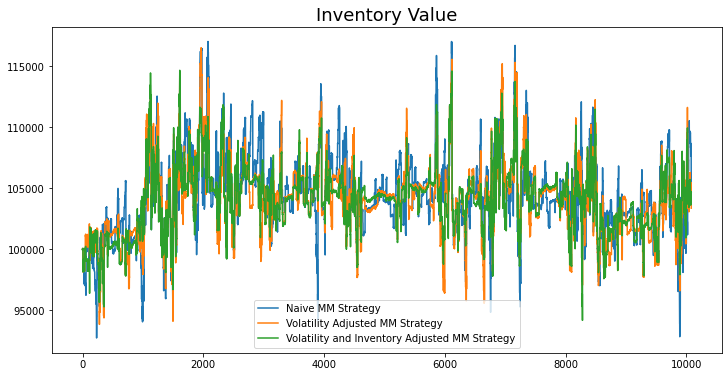

In [51]:
# now = datetime.now()
# prefix = str(now.month) + str(now.day)   
prefix = '1126'
coin = 'ETH'
DF = pd.read_csv('candles_binance_'+coin+'-USDT_1s.csv') # Candles data collected from downlaod_candles.py in Hummingbot
df1 = transform_candle_from_1s_to_1m(DF, ws)
rounding_precision = find_decimal_places(df1['open'][0])
tick_size = 10**(-rounding_precision)
performance_report(prefix, coin, df1)

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy,"Volatility, Inventory and Fair Price Adjusted MM Strategy"
Parameters,x = 1.9,"(x,s,l) = (2.0, 1, 20)","(x,s,l,k) = (2.1, 1, 20, 2.1)","(x,s,l,k,delta) = (2.1, 1, 20, 2.1, 20)"
SR of Relative P&L to Buy&Hold,-47.971974,-37.291388,-37.402688,-29.002882
Traded%,31.092437,33.613445,27.731092,31.512605
Std of Inventory Value,3342.483654,3229.037148,2904.572461,2750.002748


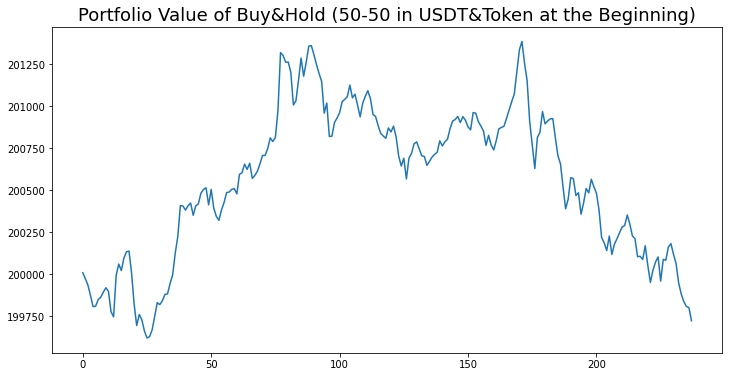

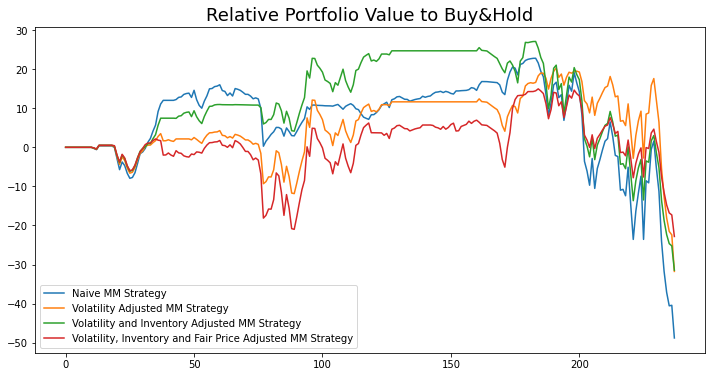

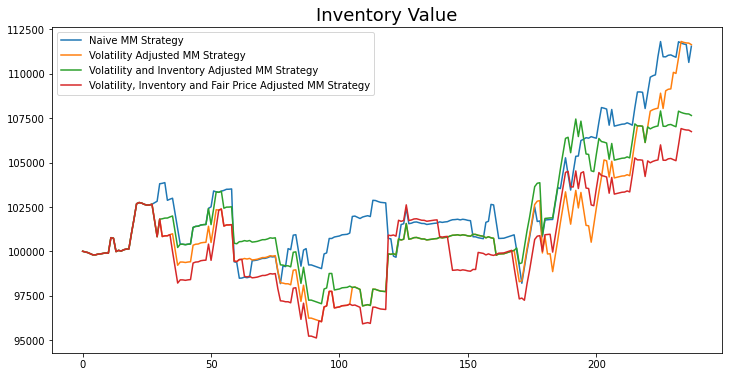

In [52]:
# Get candle data with VAMP from orderbook data
vamp_delta = 20
DF1 = get_candle_with_vamp(coin, ws, vamp_delta)
performance_report(prefix, coin, DF1, True, vamp_delta)

# DOGE Performance Report

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy
Parameters,x = 0.00014,"(x,s,l) = (0.0001, 1, 120)","(x,s,l,k) = (8e-05, 1, 120, 0.00017)"
SR of Relative P&L to Buy&Hold,2.969978,4.477259,6.253296
Traded%,22.113095,49.52381,64.275794
Std of Inventory Value,2669.193387,3510.510222,3075.087284


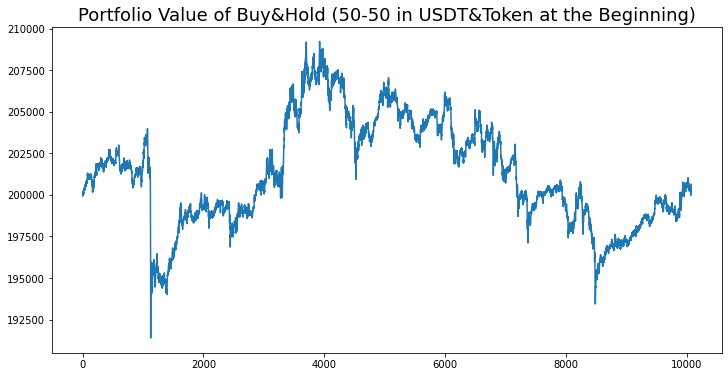

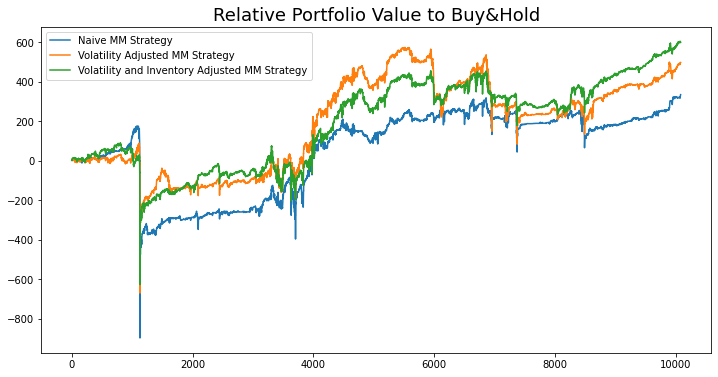

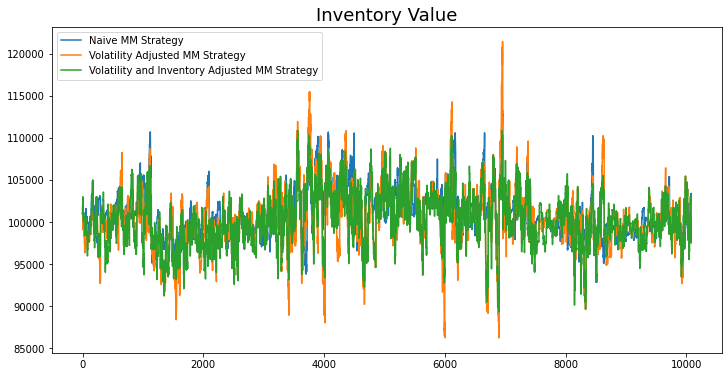

In [49]:
# now = datetime.now()
# prefix = str(now.month) + str(now.day)   
prefix = '1126'
coin = 'DOGE'
DF = pd.read_csv('candles_binance_'+coin+'-USDT_1s.csv') # Candles data collected from downlaod_candles.py in Hummingbot
df1 = transform_candle_from_1s_to_1m(DF, ws)
rounding_precision = find_decimal_places(df1['open'][0])
tick_size = 10**(-rounding_precision)
performance_report(prefix, coin, df1)

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy,"Volatility, Inventory and Fair Price Adjusted MM Strategy"
Parameters,x = 0.00014,"(x,s,l) = (0.0001, 1, 120)","(x,s,l,k) = (8e-05, 1, 120, 0.00017)","(x,s,l,k,delta) = (8e-05, 1, 120, 0.00017, 100)"
SR of Relative P&L to Buy&Hold,-66.714506,-48.229544,-60.578759,-77.195767
Traded%,27.310924,53.361345,65.12605,67.647059
Std of Inventory Value,4668.301716,4014.840901,4111.57389,3481.636673


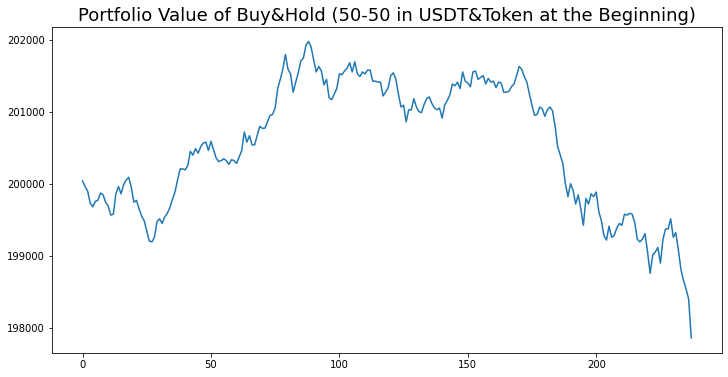

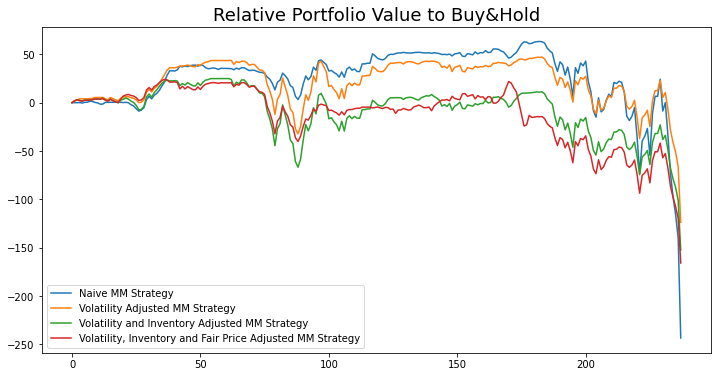

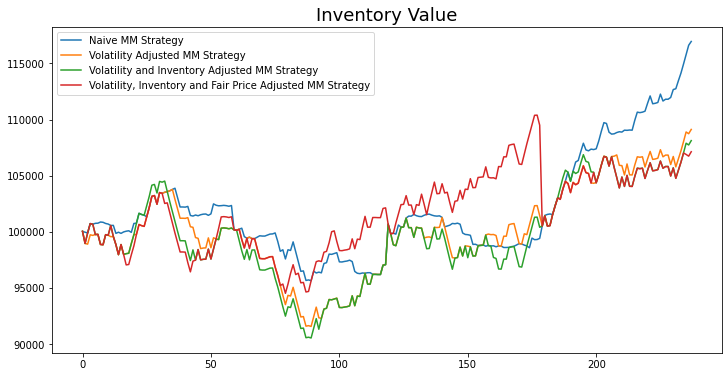

In [50]:
# Get candle data with VAMP from orderbook data
vamp_delta = 100
DF1 = get_candle_with_vamp(coin, ws, vamp_delta)
performance_report(prefix, coin, DF1, True, vamp_delta)

# CYBER Performance Report

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy
Parameters,x = 0.024,"(x,s,l) = (0.02, 1, 120)","(x,s,l,k) = (0.023, 1, 120, 0.028)"
SR of Relative P&L to Buy&Hold,12.459661,18.940195,19.764168
Traded%,27.698413,46.140873,34.751984
Std of Inventory Value,4028.242928,4766.514079,4142.348667


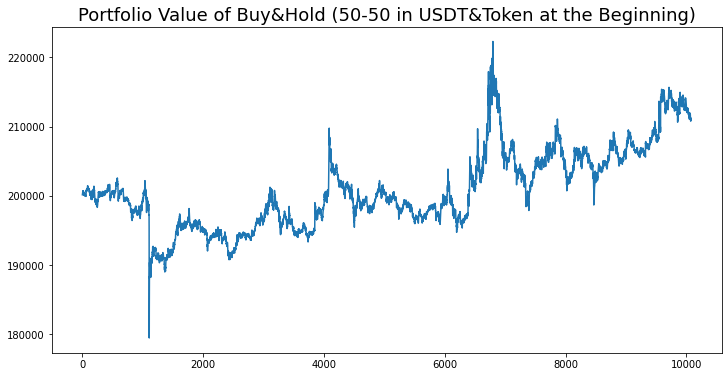

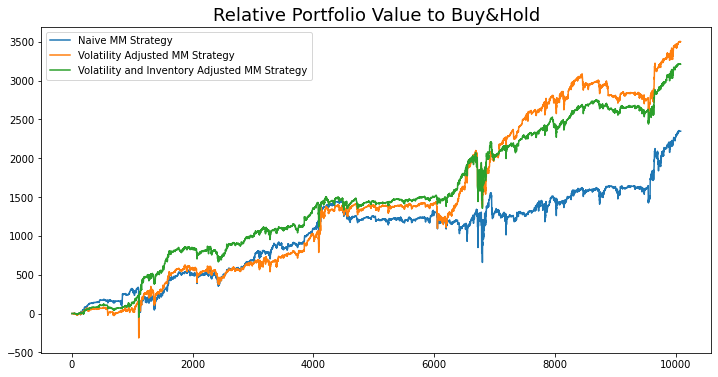

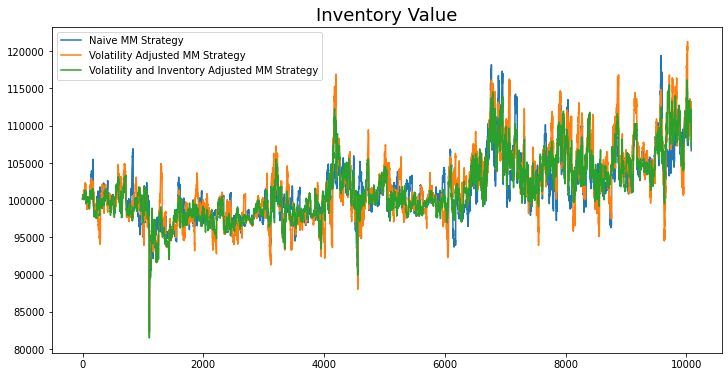

In [37]:
# now = datetime.now()
# prefix = str(now.month) + str(now.day)   
prefix = '1127'
coin = 'CYBER'
DF = pd.read_csv('candles_binance_'+coin+'-USDT_1s.csv') # Candles data collected from downlaod_candles.py in Hummingbot
df1 = transform_candle_from_1s_to_1m(DF, ws)
rounding_precision = find_decimal_places(df1['open'][0])
tick_size = 10**(-rounding_precision)
performance_report(prefix, coin, df1)

,Naive MM Strategy,Volatility Adjusted MM Strategy,Volatility and Inventory Adjusted MM Strategy,"Volatility, Inventory and Fair Price Adjusted MM Strategy"
Parameters,x = 0.024,"(x,s,l) = (0.02, 1, 120)","(x,s,l,k) = (0.023, 1, 120, 0.028)","(x,s,l,k,delta) = (0.023, 1, 120, 0.028, 100)"
SR of Relative P&L to Buy&Hold,-19.380964,14.613753,36.712036,-37.258487
Traded%,32.352941,47.058824,33.193277,44.957983
Std of Inventory Value,2709.024453,2155.751356,1287.65603,5766.987754


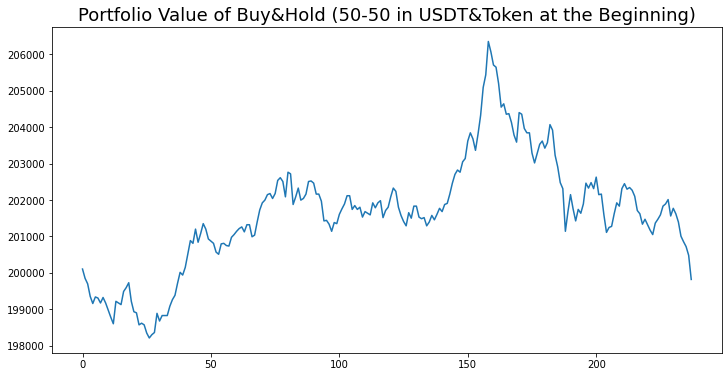

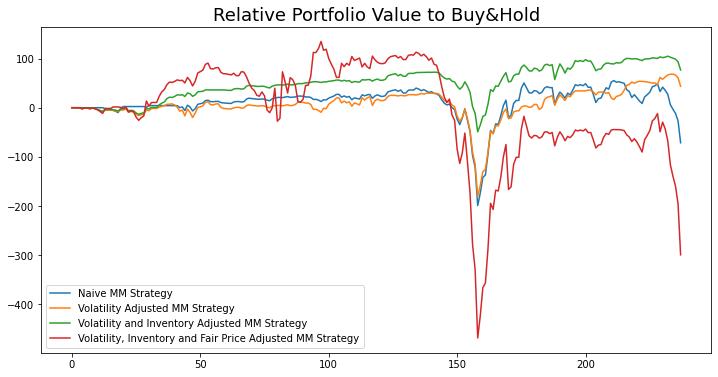

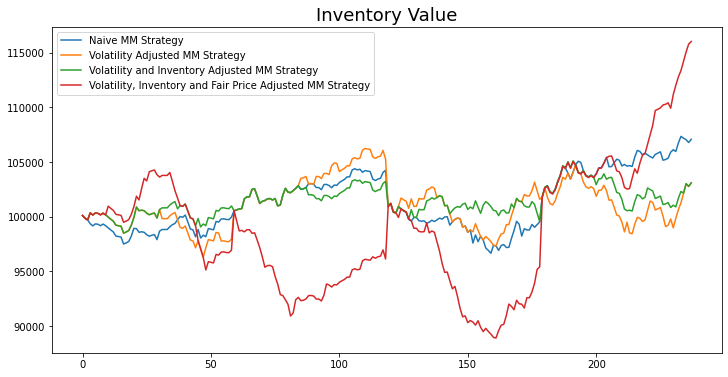

In [47]:
# Get candle data with VAMP from orderbook data
vamp_delta = 100
DF1 = get_candle_with_vamp(coin, ws, vamp_delta)
performance_report(prefix, coin, DF1, True, vamp_delta)